# Importing Libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve

# Loading Dataset

In [2]:
# Load and Explore the Dataset
data_dir = r'C:\Users\arshi\OneDrive\Desktop\College\4th year\MLH\File\Data'  # Path to dataset 

# Data Augmentation

In [3]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # Using 20% of the training data for validation
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [4]:
# Load train and validation datasets with augmentation
train_data = datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4116 images belonging to 3 classes.
Found 1028 images belonging to 3 classes.


# Exploratory Data Analysis

In [5]:
# Inspecting Dataset Distribution and Sample Images
print("Classes in the dataset:", train_data.class_indices)

Classes in the dataset: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


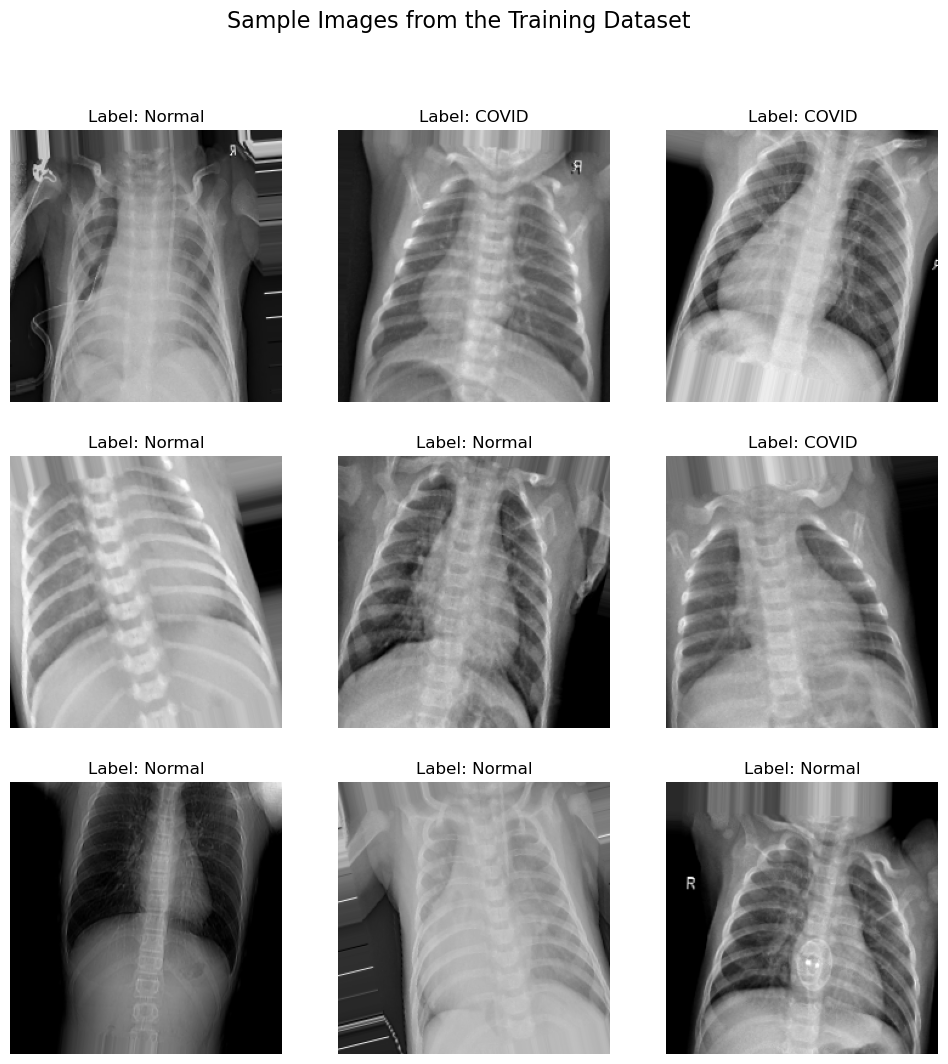

In [6]:
# Plotting a batch of sample images with labels
sample_images, sample_labels = next(train_data)
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {'COVID' if sample_labels[i] == 1 else 'Normal'}")
    plt.axis("off")
plt.suptitle("Sample Images from the Training Dataset", fontsize=16)
plt.show()

# Model Building 

In [8]:
# Building the Transfer Learning Model
# Loading the pre-trained ResNet50 model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
# Freezing all layers of the base model to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Adding custom layers on top of the ResNet50 base
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Converts features into a single vector per image
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout layer to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

In [10]:
# Defining the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
# Compile the model with binary cross-entropy loss for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Model Training 

In [14]:
#Training the Model with Validation
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    verbose=1
)

Epoch 1/10


C:\Users\arshi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 818s 6s/step - accuracy: 0.2379 - loss: -27.2062 - val_accuracy: 0.2461 - val_loss: -180.9121
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 929s 7s/step - accuracy: 0.2454 - loss: -285.9835 - val_accuracy: 0.2461 - val_loss: -697.6449
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 1152s 8s/step - accuracy: 0.2473 - loss: -891.0562 - val_accuracy: 0.2461 - val_loss: -1572.9032
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 821s 6s/step - accuracy: 0.2485 - loss: -1859.9901 - val_accuracy: 0.2461 - val_loss: -2788.5190
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 592s 5s/step - accuracy: 0.2568 - loss: -3100.4541 - val_accuracy: 0.2461 - val_loss: -4323.3613
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.2529 - loss: -4870.1572 - val_accuracy: 0.2461 - val_loss: -6182.6797
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.2373 - loss: -6844.8965 - val_accuracy: 0.2461 - val_loss: -8340.1270
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 505s 4s/step - ac

# Evaluation

In [15]:
#Evaluating the Model
# Loading test data without augmentation for evaluation
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_data = test_datagen.flow_from_directory(
    directory=os.path.join(data_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important for correctly calculating evaluation metrics
)

Found 1288 images belonging to 3 classes.


In [16]:
# Predictions
y_true = test_data.classes  # Actual labels
y_pred_probs = model.predict(test_data)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype("int32")  # Converting probabilities to binary predictions

41/41 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step


In [17]:
y_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [20]:
from sklearn.metrics import classification_report

# Classification report with zero_division parameter to handle undefined metrics
print("Classification Report:\n", classification_report(y_true, y_pred, labels=[0, 1], target_names=["Normal", "COVID"], zero_division=1))


Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.00      0.00       116
       COVID       0.25      1.00      0.40       317

   micro avg       0.25      0.73      0.37       433
   macro avg       0.62      0.50      0.20       433
weighted avg       0.45      0.73      0.29       433



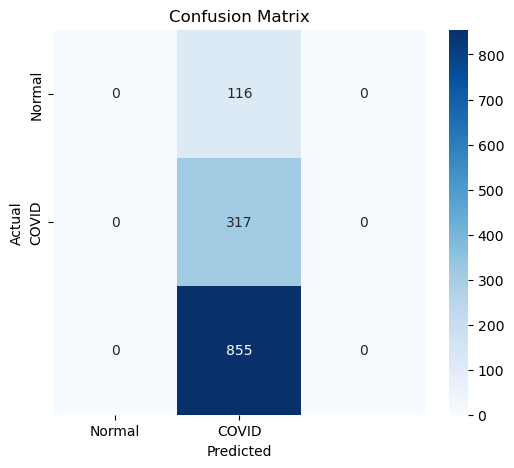

In [21]:
# Plotting the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "COVID"], yticklabels=["Normal", "COVID"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

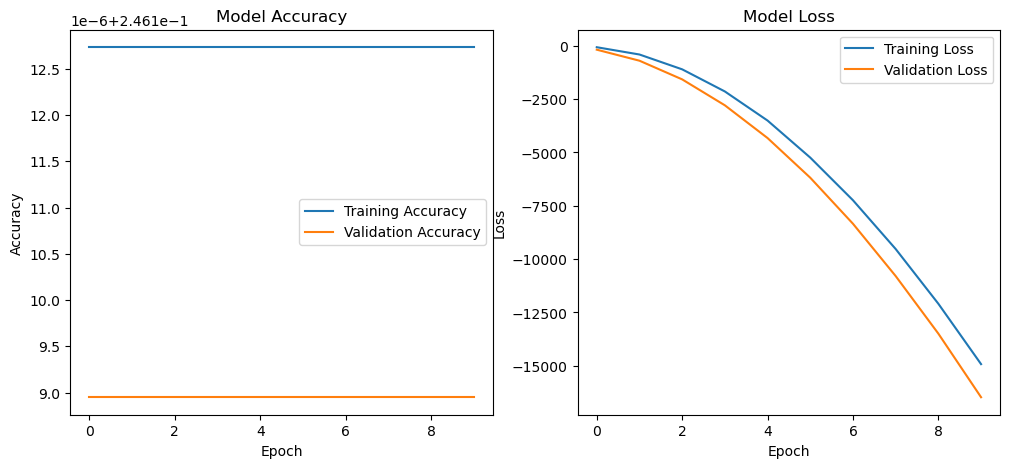

In [24]:
# Visualizing Training History for Model Performance Over Time
# Plotting accuracy and loss for training and validation data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()